## Predicting Boston Housing Prices
### Using XGBoost in SageMaker (Batch Transform)
Deep Learning Nanodegree Program | Deployment

As an introduction to using SageMaker's High Level Python API we will look at a relatively simple problem. Namely, we will use the Boston Housing Dataset to predict the median value of a home in the area of Boston Mass.

The documentation for the high level API can be found on the ReadTheDocs https://sagemaker.readthedocs.io/en/latest/ page

### General Outline
Typically, when using a notebook instance with SageMaker, you will proceed through the following steps. Of course, not every step will need to be done with each project. Also, there is quite a lot of room for variation in many of the steps, as you will see throughout these lessons.

- Download or otherwise retrieve the data.
- Process / Prepare the data.
- Upload the processed data to S3.
- Train a chosen model.
- Test the trained model (typically using a batch transform job).
- Deploy the trained model.
- Use the deployed model.

In this notebook we will only be covering steps 1 through 5 as we just want to get a feel for using SageMaker. In later notebooks we will talk about deploying a trained model in much more detail.

In [1]:
# Make sure that we use SageMaker 1.x
#!pip install sagemaker==1.72.0

You should consider upgrading via the 'c:\users\evaes\anaconda3\python.exe -m pip install --upgrade pip' command.


### Step 0: Setting up the notebook

We begin by setting up all of the necessary bits required to run our notebook. To start that means loading all of the Python modules we will need.

In [2]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

#from sklearn.datasets import load_boston
import sklearn.model_selection

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In addition to the modules above, we need to import the various bits of SageMaker that we will be using.

In [3]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

ValueError: Must setup local AWS configuration with a region supported by SageMaker.

### Step 1: Downloading the data
Fortunately, this dataset can be retrieved using sklearn and so this step is relatively straightforward.

In [5]:
strings = {'Sección' : 'str', 'cod_ccaa' : 'str', 'cod_prov' : 'str', 'cod_mun' : 'str'}

In [6]:
#df_eleccion = pd.read_csv('gen_A19_unif_cols_prov_copia.txt', dtype = strings)
df_eleccion = pd.read_csv('gen_N19_unif_cols_prov_copia.txt', dtype = strings)

In [7]:
df_eleccion.head().T

,0,1,2,3,4
Sección,022019111010400101001,022019111010400201001,022019111010400301001,022019111010400301002,022019111010400301003
cod_ccaa,01,01,01,01,01
cod_prov,04,04,04,04,04
cod_mun,04001,04002,04003,04003,04003
cod_sec,400101001,400201001,400301001,400301002,400301003
CCAA,Andalucía,Andalucía,Andalucía,Andalucía,Andalucía
Provincia,Almería,Almería,Almería,Almería,Almería
Municipio,Abla,Abrucena,Adra,Adra,Adra
Censo_Esc,1002,1013,667,1306,1551
Votos_Total,717,711,484,909,975


In [8]:
df_eleccion.columns

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

In [10]:
df_eleccion['% Vox'].describe()

count    36299.000000
mean         0.149372
std          0.080258
min          0.000000
25%          0.088054
50%          0.149819
75%          0.201411
max          0.666667
Name: % Vox, dtype: float64

In [11]:
df_eleccion['% Vox'].isna().sum()

3

In [12]:
df_eleccion.loc[df_eleccion['% Vox'].isna()]

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,% PP,% PSOE,% UP,% Vox,% Cs,% IU,Ganador,Segundo,Tercero,Cuarto,Quinto,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
4686,022019111014100701002,01,41,41007,4100701002,Andalucía,Sevilla,La Algaba,900,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,PP,PSOE,Cs,UP,IU,86.0,88.0,61.0,58.0,51.0,69.0,66.0,140.0,104.0,95.0,86.0,66.0,61.0,49.0,40.0,38.0,22.0,13.0,4.0,2.0,0.0,1199.0,582.0,617.0,0.140117,0.615513,0.244370,2549.0,0.296195,2.125938,2493.0,0.395909,0.500602,0.494447,8267.0,7610.0,24288.0,22082.0,6506.0,5395.0,1766.0,1867.0,355.0,330.0,"{'PP': 0, 'PSOE': 0, 'Cs': 0, 'UP': 0, 'IU': 0, 'VOX': 0, 'UPyD': 0, 'MP': 0, 'CiU': 0, 'ERC': 0, 'JxC': 0, 'CUP': 0, 'DiL': 0, 'PNV': 0, 'Bildu': 0, 'Amaiur': 0, 'CC': 0, 'FA': 0, 'TE': 0, 'BNG': 0, 'PRC': 0, 'GBai': 0, 'Compromis': 0, 'PACMA': 0, 'Otros': 0}","[('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0), ('IU', 0), ('VOX', 0), ('UPyD', 0), ('MP', 0), ('CiU', 0), ('ERC', 0), ('JxC', 0), ('CUP', 0), ('DiL', 0), ('PNV', 0), ('Bildu', 0), ('Amaiur', 0), ('CC', 0), ('FA', 0), ('TE', 0), ('BNG', 0), ('PRC', 0), ('GBai', 0), ('Compromis', 0), ('PACMA', 0), ('Otros', 0)]"
32884,022019111170301403031,17,03,03014,301403031,La Rioja,Alicante,Alicante / Alacant,752,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,PP,PSOE,Cs,UP,IU,48.0,57.0,51.0,51.0,41.0,70.0,74.0,95.0,77.0,85.0,72.0,74.0,82.0,80.0,39.0,39.0,28.0,12.0,8.0,3.0,0.0,1086.0,542.0,544.0,0.192449,0.616943,0.190608,183456.0,0.107573,168.928177,34757.0,0.439336,0.549040,0.159280,7944.0,7806.0,20487.0,19290.0,5159.0,4807.0,2898.0,2825.0,316.0,385.0,"{'PP': 0, 'PSOE': 0, 'Cs': 0, 'UP': 0, 'IU': 0, 'VOX': 0, 'UPyD': 0, 'MP': 0, 'CiU': 0, 'ERC': 0, 'JxC': 0, 'CUP': 0, 'DiL': 0, 'PNV': 0, 'Bildu': 0, 'Amaiur': 0, 'CC': 0, 'FA': 0, 'TE': 0, 'BNG': 0, 'PRC': 0, 'GBai': 0, 'Compromis': 0, 'PACMA': 0, 'Otros': 0}","[('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0), ('IU', 0), ('VOX', 0), ('UPyD', 0), ('MP', 0), ('CiU', 0), ('ERC', 0), ('JxC', 0), ('CUP', 0), ('DiL', 0), ('PNV', 0), ('Bildu', 0), ('Amaiur', 0), ('CC', 0), ('FA', 0), ('TE', 0), ('BNG', 0), ('PRC', 0), ('GBai', 0), ('Compromis', 0), ('PACMA', 0), ('Otros', 0)]"
32968,022019111170301406007,17,03,03014,301406007,La Rioja,Alicante,Alicante / Alacant,709,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,PP,PSOE,Cs,UP,IU,54.0,53.0,49.0,63.0,63.0,73.0,75.0,87.0,85.0,89.0,75.0,90.0,39.0,39.0,50.0,41.0,38.0,21.0,8.0,1.0,0.0,1093.0,511.0,582.0,0.181153,0.618481,0.200366,183456.0,0.107573,167.846295,34757.0,0.439336,0.549040,0.159280,7592.0,6880.0,18941.0,16729.0,5222.0,4137.0,2256.0,2468.0,385.0,382.0,"{'PP': 0, 'PSOE': 0, 'Cs': 0, 'UP': 0, 'IU': 0, 'VOX': 0, 'UPyD': 0, 'MP': 0, 'CiU': 0, 'ERC': 0, 'JxC': 0, 'CUP': 0, 'DiL': 0, 'PNV': 0, 'Bildu': 0, 'Amaiur': 0, 'CC': 0, 'FA': 0, 'TE': 0, 'BNG': 0, 'PRC': 0, 'GBai': 0, 'Compromis': 0, 'PACMA': 0, 'Otros': 0}","[('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0), ('IU', 0), ('VOX', 0), ('UPyD', 0), ('MP', 0), ('CiU', 0), ('ERC', 0), ('JxC', 0), ('CUP', 0), ('DiL', 0), ('PNV', 0), ('Bildu', 0), ('Amaiur', 0), ('CC', 0), ('FA', 0), ('TE', 0), ('BNG', 0), ('PRC', 0),

In [14]:
df_eleccion['VOX'].sum()

3640377

In [15]:
df_eleccion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36302 entries, 0 to 36301
Data columns (total 97 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Sección                           36302 non-null  object 
 1   cod_ccaa                          36302 non-null  object 
 2   cod_prov                          36302 non-null  object 
 3   cod_mun                           36302 non-null  object 
 4   cod_sec                           36302 non-null  int64  
 5   CCAA                              36302 non-null  object 
 6   Provincia                         36302 non-null  object 
 7   Municipio                         36302 non-null  object 
 8   Censo_Esc                         36302 non-null  int64  
 9   Votos_Total                       36302 non-null  int64  
 10  Participación                     36302 non-null  float64
 11  Nulos                             36302 non-null  int64  
 12  Voto

In [16]:
#añado CCAA y me cargo 0-4,5-9,10-14
cols_validas = ['% Vox','CCAA','Provincia',
        'Censo_Esc', 'Participación',
         '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015']

In [17]:
df_eleccion = df_eleccion[cols_validas]

In [18]:
df_eleccion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36302 entries, 0 to 36301
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   % Vox                             36299 non-null  float64
 1   CCAA                              36302 non-null  object 
 2   Provincia                         36302 non-null  object 
 3   Censo_Esc                         36302 non-null  int64  
 4   Participación                     36302 non-null  float64
 5   15-19                             36287 non-null  float64
 6   20-24                             36287 non-null  float64
 7   25-29                             36287 non-null  float64
 8   30-34                             36287 non-null  float64
 9   35-39                             36287 non-null  float64
 10  40-44                             36287 non-null  float64
 11  45-49                             36287 non-null  float64
 12  50-5

In [21]:
FillNA_num_mean = ['Censo_Esc', 'Participación','15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015']

In [22]:
for item in FillNA_num_mean:
        
    df_eleccion[item].fillna(df_eleccion[item].mean(), inplace=True)

In [23]:
categorical = ['Provincia']

In [25]:
df_eleccion['Provincia'].value_counts().sum()

36302

In [27]:
mean_map1 = {}
for c in categorical:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_eleccion.groupby(c)['% Vox'].mean()
    df_eleccion[c] = df_eleccion[c].map(mean)    
    mean_map1[c] = mean

<ipython-input-27-8c1e1bf628f6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eleccion[c] = df_eleccion[c].map(mean)


In [28]:
mean_map1

{'Provincia': Provincia
 Albacete                  0.201802
 Alicante                  0.191239
 Almería                   0.260176
 Asturias                  0.157735
 Badajoz                   0.167461
 Barcelona                 0.063867
 Burgos                    0.147452
 Cantabria                 0.147593
 Castellón                 0.180002
 Ceuta                     0.344790
 Ciudad Real               0.206365
 Cuenca                    0.176282
 Cáceres                   0.155264
 Cádiz                     0.210830
 Córdoba                   0.182059
 Gerona                    0.049243
 Gipúzcoa                  0.018261
 Granada                   0.203506
 Guadalajara               0.198993
 Huelva                    0.202087
 Huesca                    0.143875
 Islas Baleares            0.171002
 Jaén                      0.194151
 La Coruña                 0.081391
 La Rioja                  0.106458
 Las Palmas                0.132213
 León                      0.154319
 Lug

In [29]:
categorical2 = ['CCAA']

In [30]:
categorical2

['CCAA']

In [31]:
mean_map2 = {}
for c in categorical2:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_eleccion.groupby(c)['% Vox'].mean()
    df_eleccion[c] = df_eleccion[c].map(mean)    
    mean_map2[c] = mean

<ipython-input-31-ce2f5aa38250>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eleccion[c] = df_eleccion[c].map(mean)


In [32]:
mean_map2

{'CCAA': CCAA
 'Islas Baleares'        0.171002
 Andalucía               0.201030
 Aragón                  0.158517
 Asturias                0.157735
 C. Valenciana           0.162253
 Canarias                0.124092
 Cantabria               0.147593
 Castilla - La Mancha    0.163789
 Castilla y León         0.205507
 Cataluña                0.061676
 Ceuta                   0.344790
 Extremadura             0.077410
 Galicia                 0.176556
 La Rioja                0.181703
 Madrid                  0.051186
 Melilla                 0.172633
 Murcia                  0.024023
 Navarra                 0.279218
 País Vasco              0.106458
 Name: % Vox, dtype: float64}

In [33]:
df_eleccion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36302 entries, 0 to 36301
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   % Vox                             36299 non-null  float64
 1   CCAA                              36302 non-null  float64
 2   Provincia                         36302 non-null  float64
 3   Censo_Esc                         36302 non-null  int64  
 4   Participación                     36302 non-null  float64
 5   15-19                             36302 non-null  float64
 6   20-24                             36302 non-null  float64
 7   25-29                             36302 non-null  float64
 8   30-34                             36302 non-null  float64
 9   35-39                             36302 non-null  float64
 10  40-44                             36302 non-null  float64
 11  45-49                             36302 non-null  float64
 12  50-5

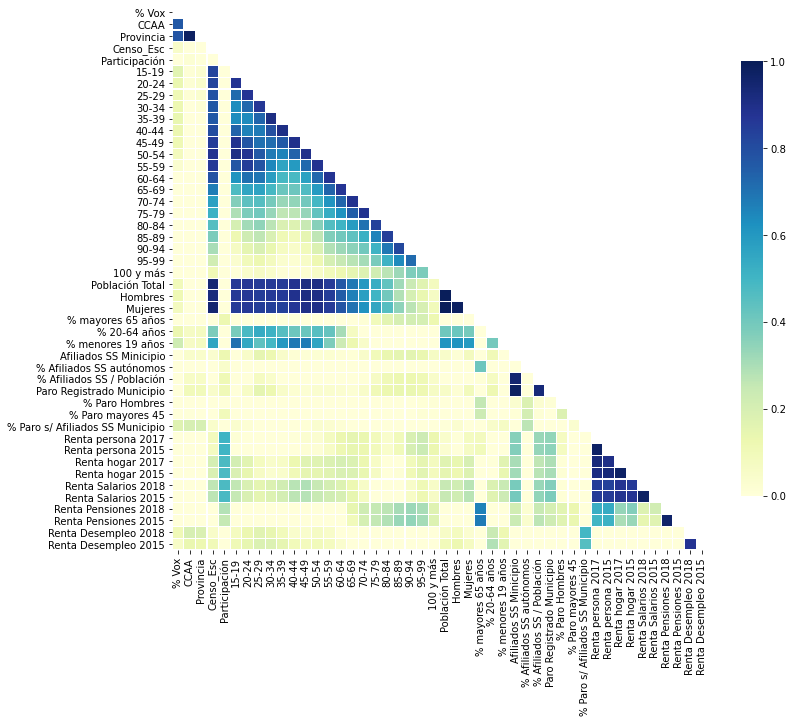

In [35]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_eleccion).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [36]:
df_eleccion = df_eleccion.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [39]:
df_eleccion['% Vox'].isna().sum() #por qué no lo hemos sustituido por la media?

3

In [40]:
df_eleccion = df_eleccion[df_eleccion['% Vox'].notnull()]

In [ ]:
#datos limpios y numéricos. AHORA TOCA DIVIDIR EN TRAIN TEST Y X E Y

### Step 2: Preparing and splitting the data

Given that this is clean tabular data, we don't need to do any processing. However, we do need to split the rows in the dataset up into train, test and validation sets.

In [50]:
# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.
data = df_eleccion.values
y = data[:,0:1]     
X = data[:,1:]      
feature_names = df_eleccion.columns[1:]
X_dfN19_pd = pd.DataFrame(X, columns= feature_names)
Y_dfN19_pd = pd.DataFrame(y)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_dfN19_pd, Y_fN19_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

### Step 3: Uploading the data files to S3
When a training job is constructed using SageMaker, a container is executed which performs the training operation. This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. In addition, when we perform a batch transform job, SageMaker expects the input data to be stored on S3. We can use the SageMaker API to do this and hide some of the details.

#### Save the data locally
First we need to create the test, train and validation csv files which we will then upload to S3.

In [53]:
# This is our local data directory. We need to make sure that it exists.
data_dir = 'data/N19'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [54]:
# We use pandas to save our test, train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, for the train and
# validation data, it is assumed that the first entry in each row is the target variable.

X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

#### Upload to S3
Since we are currently running inside of a SageMaker session, we can use the object which represents this session to upload our data to the 'default' S3 bucket. Note that it is good practice to provide a custom prefix (essentially an S3 folder) to make sure that you don't accidentally interfere with data uploaded from some other notebook or project.

In [ ]:
prefix = 'N19-HL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

### Step 4: Train the XGBoost model

Now that we have the training and validation data uploaded to S3, we can construct our XGBoost model and train it. We will be making use of the high level SageMaker API to do this which will make the resulting code a little easier to read at the cost of some flexibility.

To construct an estimator, the object which we wish to train, we need to provide the location of a container which contains the training code. Since we are using a built in algorithm this container is provided by Amazon. However, the full name of the container is a bit lengthy and depends on the region that we are operating in. Fortunately, SageMaker provides a useful utility method called get_image_uri that constructs the image name for us.

To use the get_image_uri method we need to provide it with our current region, which can be obtained from the session object, and the name of the algorithm we wish to use. In this notebook we will be using XGBoost however you could try another algorithm if you wish. The list of built in algorithms can be found in the list of Common Parameters.

In [ ]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost')

#from sagemaker import image_uris OTRA OPCIÓN SI ESA FALLA
#container = image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

Before asking SageMaker to begin the training job, we should probably set any model specific hyperparameters. There are quite a few that can be set when using the XGBoost algorithm, below are just a few of them. If you would like to change the hyperparameters below or modify additional ones you can find additional information on the XGBoost hyperparameter page

In [ ]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

Now that we have our estimator object completely set up, it is time to train it. To do this we make sure that SageMaker knows our input data is in csv format and then execute the fit method.

In [ ]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

### Step 5: Test the model
Now that we have fit our model to the training data, using the validation data to avoid overfitting, we can test our model. To do this we will make use of SageMaker's Batch Transform functionality. To start with, we need to build a transformer object from our fit model.

In [ ]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Next we ask SageMaker to begin a batch transform job using our trained model and applying it to the test data we previously stored in S3. We need to make sure to provide SageMaker with the type of data that we are providing to our model, in our case text/csv, so that it knows how to serialize our data. In addition, we need to make sure to let SageMaker know how to split our data up into chunks if the entire data set happens to be too large to send to our model all at once.

Note that when we ask SageMaker to do this it will execute the batch transform job in the background. Since we need to wait for the results of this job before we can continue, we use the wait() method. An added benefit of this is that we get some output from our batch transform job which lets us know if anything went wrong.

In [ ]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [ ]:

xgb_transformer.wait()

Now that the batch transform job has finished, the resulting output is stored on S3. Since we wish to analyze the output inside of our notebook we can use a bit of notebook magic to copy the output file from its S3 location and save it locally.

In [ ]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

To see how well our model works we can create a simple scatter plot between the predicted and actual values. If the model was completely accurate the resulting scatter plot would look like the line $x=y$. As we can see, our model seems to have done okay but there is room for improvement.

In [ ]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [ ]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median vote percentage")
plt.ylabel("Predicted vote percentage")
plt.title("Median vote percentage vs Predicted vote percentage")

### Optional: Clean up
The default notebook instance on SageMaker doesn't have a lot of excess disk space available. As you continue to complete and execute notebooks you will eventually fill up this disk space, leading to errors which can be difficult to diagnose. Once you are completely finished using a notebook it is a good idea to remove the files that you created along the way. Of course, you can do this from the terminal or from the notebook hub if you would like. The cell below contains some commands to clean up the created files from within the notebook.

In [ ]:
# First we will remove all of the files contained in the data_dir directory
#!rm $data_dir/*

# And then we delete the directory itself
#!rmdir $data_dir